In [1]:
import agama
import numpy
import matplotlib
import matplotlib.pyplot as plt
from subprocess import Popen, PIPE
import subprocess
from scipy.signal import fftconvolve
import os
import itertools
import shutil
from scipy.interpolate import UnivariateSpline

from photutils.isophote import Ellipse
from matplotlib import colors
from tqdm import trange, tqdm
from scipy import stats
import pandas as pds
from mgefit import *
from mgefit.find_galaxy import find_galaxy
from astropy.io import fits
from astropy.modeling import models
from petrofit.modeling import fit_model
import math
from petrofit.modeling import print_model_params
from petrofit.modeling import plot_fit
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from scipy import interpolate

In [3]:
def fourParamScatter(x, y, c, labels):
    legends = [Line2D([0], [0], marker='+', label='$\gamma = 0.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='x', label='$\gamma = 0.75$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='s', label='$\gamma = 1$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='o', label='$\gamma = 1.25$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'),
          Line2D([0], [0], marker='d', label='$\gamma = 1.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k')]
    
    fig, ax = plt.subplots(figsize=(12,11))


    mark = 0
    for xi,yi,ci in zip(x ,y, c):
        if gammas[mark] == 0.5:
            im = ax.scatter(xi,yi, c=ci, marker = "+", s=70, vmin=min(c), vmax=max(c), cmap = "plasma")
        if gammas[mark] == 0.75:
            im = ax.scatter(xi,yi, c=ci, marker = "x", s=70, vmin=min(c), vmax=max(c), cmap = "plasma")
        if gammas[mark] == 1:
            im = ax.scatter(xi,yi, c=ci, marker = "s", s=70, vmin=min(c), vmax=max(c), cmap = "plasma")
        if gammas[mark] == 1.25:
            im = ax.scatter(xi,yi, c=ci, marker = "o", s=70, vmin=min(c), vmax=max(c), cmap = "plasma")
        if gammas[mark] == 1.5:
            im = ax.scatter(xi,yi, c=ci, marker = "d", s=70, vmin=min(c), vmax=max(c), cmap = "plasma")
        
        mark += 1
    
    fig.colorbar(im, ax=ax, label = labels[0])

    ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True)

    #ax.legend(handles=legends, fontsize = "18")
    plt.xlabel(labels[1])
    plt.ylabel(labels[2])
    
    plt.show()
    return

In [4]:
def plot2DInter(sers, r, a, gamm, print = False):
    tck = interpolate.bisplrep(sers, r, a)
    if print:
        print(tck)
    xNew = numpy.linspace(min(sers), max(sers), 1000)
    yNew = numpy.linspace(min(r), max(r), 1000)
    fxy = interpolate.bisplev(xNew, yNew, tck)
    
    tck2 = interpolate.bisplrep(sers, r, gamm)
    fxy2 = interpolate.bisplev(xNew, yNew, tck2)
    if print:
        print(tck2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
    im = ax1.pcolor(xNew2, yNew2, fxy2, cmap = "plasma", vmin = min(gamm), vmax = max(gamm))
    cbar1 = fig.colorbar(im, ax=ax1, location = "top")
    cbar1.set_label(label = "$\gamma$", labelpad = 15)

    im1 = ax2.pcolor(xNew, yNew, fxy, cmap = "plasma", vmin = min(a), vmax = max(a))
    cbar2 = fig.colorbar(im1, ax=ax2, location = "top")
    cbar2.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)

    fig.text(0.5, 0.02, '$n$', ha='center')
    fig.text(0.01, 0.5, '$r_{1/2}\;2D\;\mathrm{[kpc]}$', va='center', rotation='vertical')

    plt.show()
    return

In [5]:
mockName, gamma, scaleRads, cutoffRads, rEff2d, rEff3d, rHalf2d, rHalf3d, sersInds, sersRs, snapName, imgName = numpy.loadtxt("UCD_mock_params.txt", dtype = str, unpack = True)

In [6]:
mockName_cE, gamma_cE, scaleRads_cE, cutoffRads_cE, rEff2d_cE, rEff3d_cE, rHalf2d_cE, rHalf3d_cE, sersInds_cE, sersRs_cE, snapName_cE, imgName_cE = numpy.loadtxt("mock_params_cEs.txt", dtype = str, unpack = True)


In [7]:
gammas = []
for gam in gamma:
    gammas.append(float(gam))
    
scales = []
for a in scaleRads:
    scales.append(float(a))
    
sersInd = []
for n in sersInds:
    sersInd.append(float(n))

In [8]:
gammas_cE = []
for gam in gamma_cE:
    gammas_cE.append(float(gam))
    
scales_cE = []
for a in scaleRads_cE:
    scales_cE.append(float(a))
    
sersInd_cE = []
for n in sersInds_cE:
    sersInd_cE.append(float(n))

In [9]:
twoDimHalf = []
threeDimHalf = []
for twoD, threeD in zip(rHalf2d, rHalf3d):
    x = twoD.strip("(,'")
    y = threeD.strip("),'")
    twoDimHalf.append(float(x))
    threeDimHalf.append(float(y))
    
twoDimEff = []
threeDimEff = []

for twoDi, threeDi in zip(rEff2d, rEff3d):
    x = twoDi.strip("(,'")
    y = threeDi.strip("),'")
    twoDimEff.append(float(x))
    threeDimEff.append(float(y))

In [10]:
twoDimHalf_cE = []
threeDimHalf_cE = []
for twoD, threeD in zip(rHalf2d_cE, rHalf3d_cE):
    x = twoD.strip("(,'")
    y = threeD.strip("),'")
    twoDimHalf_cE.append(float(x))
    threeDimHalf_cE.append(float(y))
    
twoDimEff_cE = []
threeDimEff_cE = []

for twoDi, threeDi in zip(rEff2d_cE, rEff3d_cE):
    x = twoDi.strip("(,'")
    y = threeDi.strip("),'")
    twoDimEff_cE.append(float(x))
    threeDimEff_cE.append(float(y))

## Plot 2D vs 3D $r_{1/2}$ and $r_{e}$

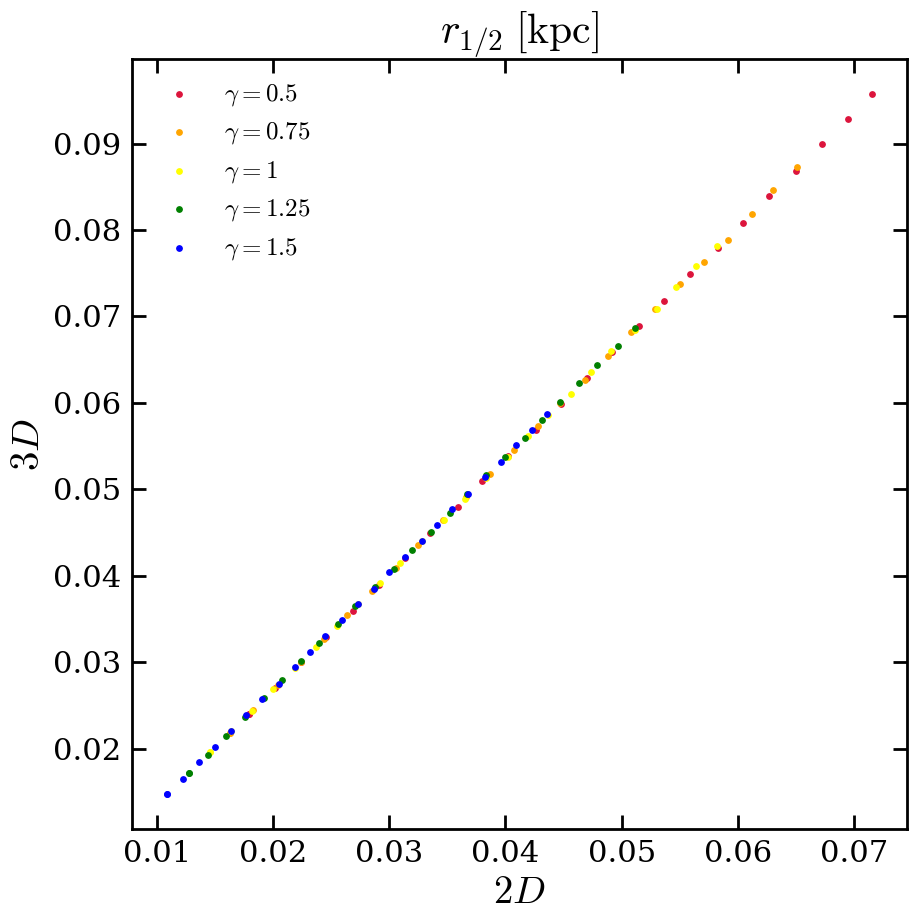

In [11]:
n1 = 0
n2 = 0
n3 = 0
n4 = 0
n5 = 0
for i in range(0, len(gammas)):
    if gammas[i] == 0.5:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "crimson")
    if gammas[i] == 0.75:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "orange")
    if gammas[i] == 1:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "yellow")
    if gammas[i] == 1.25:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "green")
    if gammas[i] == 1.5:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "blue")
    if gammas[i] == 0.5 and n1 == 0:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "crimson", label = "$\gamma = 0.5$")
        n1 += 1
    if gammas[i] == 0.75 and n2 == 0:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "orange", label = "$\gamma = 0.75$")
        n2 += 1
    if gammas[i] == 1 and n3 == 0:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "yellow", label = "$\gamma = 1$")
        n3 += 1
    if gammas[i] == 1.25 and n4 == 0:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "green", label = "$\gamma = 1.25$")
        n4 += 1
    if gammas[i] == 1.5 and n5 == 0:
        plt.scatter(twoDimHalf[i], threeDimHalf[i], s = 15, color = "blue", label = "$\gamma = 1.5$")
        n5 += 1

plt.xlabel("$2D$")
plt.ylabel("$3D$")
plt.title("$r_{1/2} \; \mathrm{[kpc]}$")
plt.legend(fontsize = "18")
plt.show()

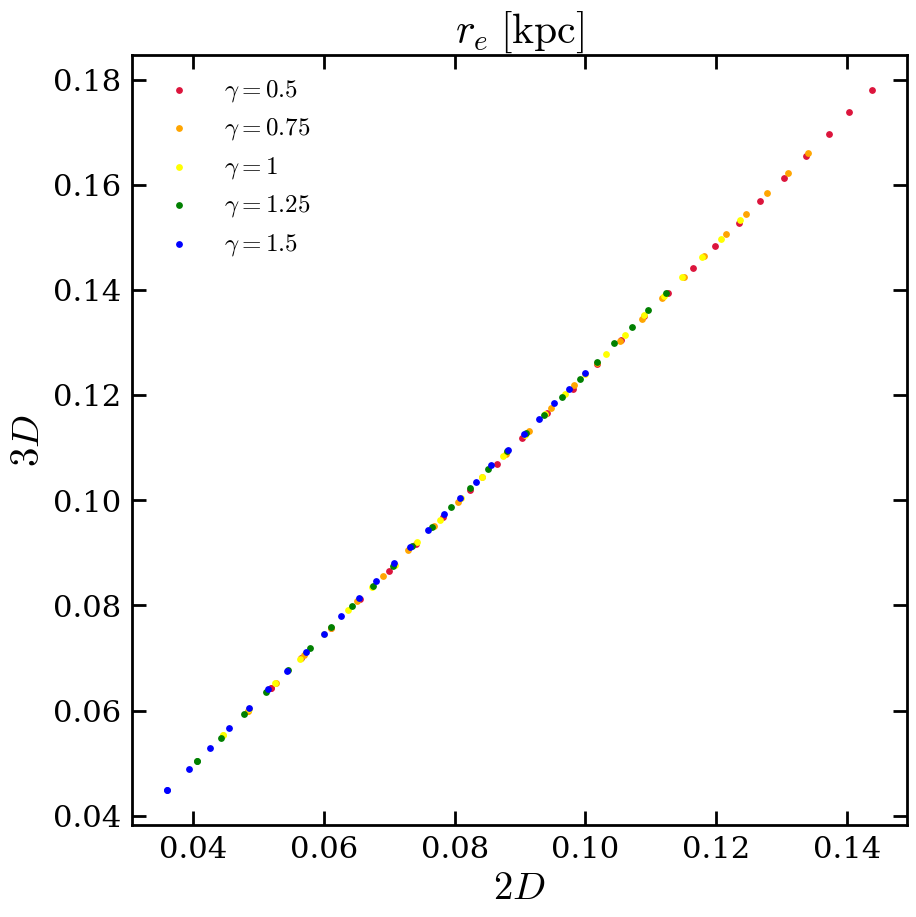

In [12]:
n1 = 0
n2 = 0
n3 = 0
n4 = 0
n5 = 0
for i in range(0, len(gammas)):
    if gammas[i] == 0.5:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "crimson")
    if gammas[i] == 0.75:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "orange")
    if gammas[i] == 1:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "yellow")
    if gammas[i] == 1.25:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "green")
    if gammas[i] == 1.5:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "blue")
    if gammas[i] == 0.5 and n1 == 0:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "crimson", label = "$\gamma = 0.5$")
        n1 += 1
    if gammas[i] == 0.75 and n2 == 0:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "orange", label = "$\gamma = 0.75$")
        n2 += 1
    if gammas[i] == 1 and n3 == 0:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "yellow", label = "$\gamma = 1$")
        n3 += 1
    if gammas[i] == 1.25 and n4 == 0:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "green", label = "$\gamma = 1.25$")
        n4 += 1
    if gammas[i] == 1.5 and n5 == 0:
        plt.scatter(twoDimEff[i], threeDimEff[i], s = 15, color = "blue", label = "$\gamma = 1.5$")
        n5 += 1

plt.xlabel("$2D$")
plt.ylabel("$3D$")
plt.title("$r_{e} \; \mathrm{[kpc]}$")
plt.legend(fontsize = "18")
plt.show()

# Fill

In [13]:
legends = [Line2D([0], [0], marker='+', label='$\gamma = 0.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='x', label='$\gamma = 0.75$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='s', label='$\gamma = 1$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='o', label='$\gamma = 1.25$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'),
          Line2D([0], [0], marker='d', label='$\gamma = 1.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k')]

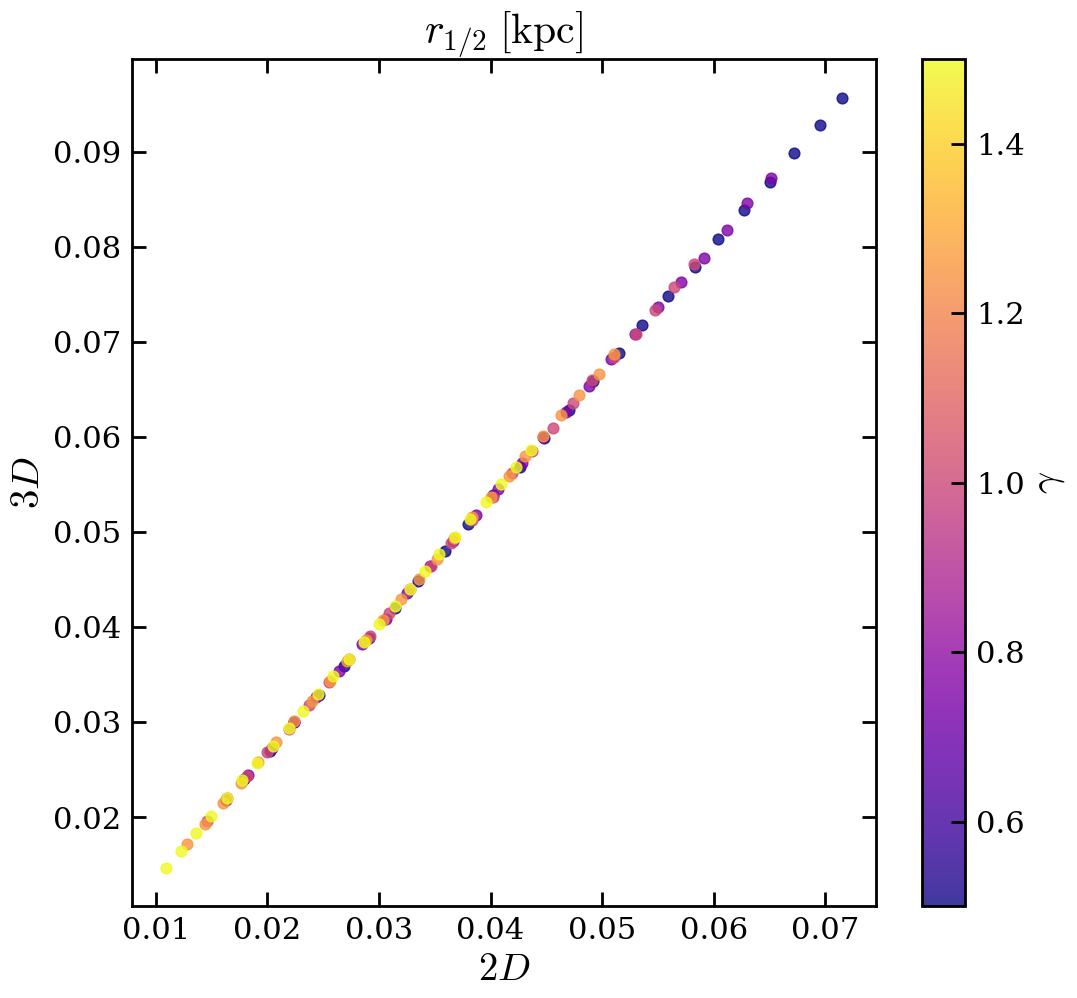

In [14]:
fig, ax = plt.subplots(figsize=(12,11))
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,ci in zip(twoDimHalf, threeDimHalf, gammas):

    im = ax.scatter(xi,yi, c=ci, s=60, vmin=min(gammas), vmax=max(gammas), cmap = "plasma", alpha = 0.8)
        
    mark += 1
fig.colorbar(im, ax=ax, label = "$\gamma$")

#ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))
plt.xlabel("$2D$")
plt.ylabel("$3D$")
plt.title("$r_{1/2}\;\mathrm{[kpc]}$")
    
plt.show()

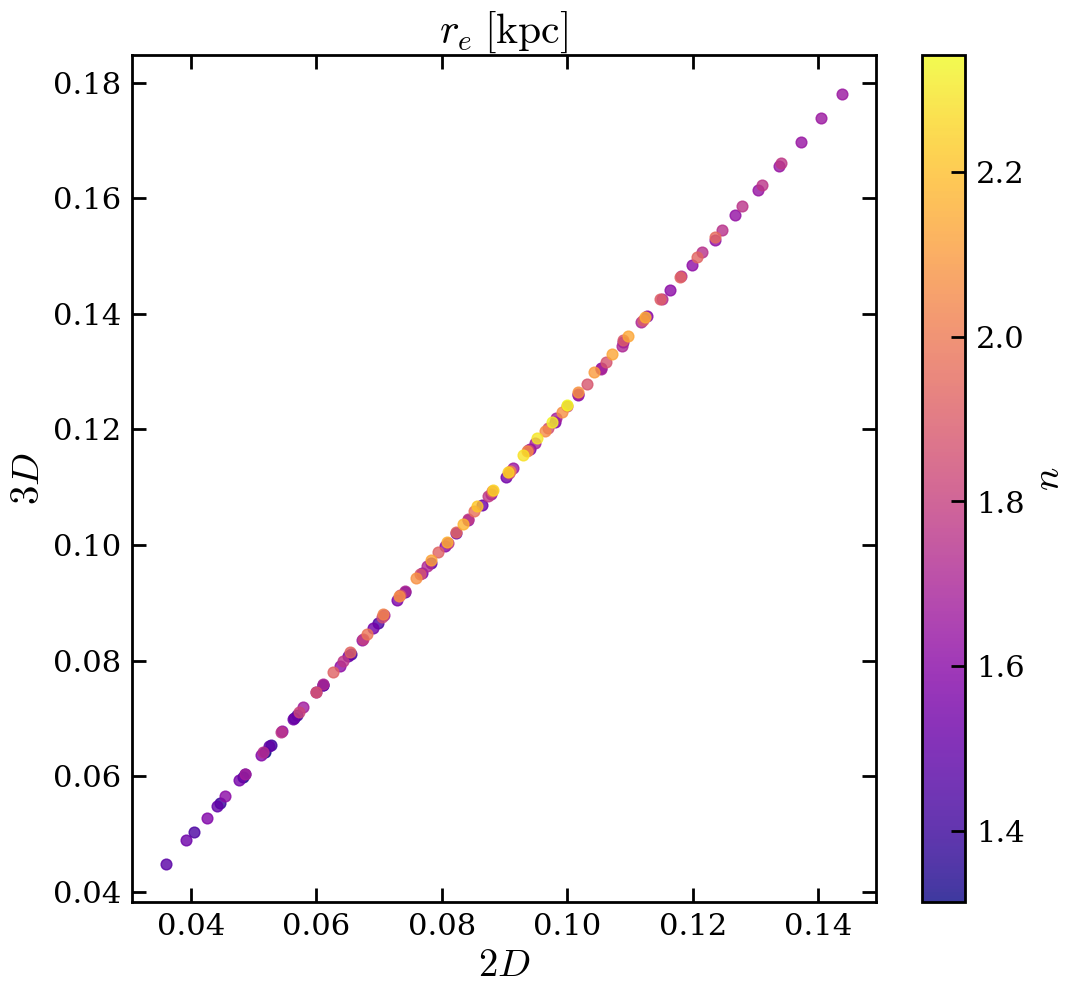

In [15]:
fig, ax = plt.subplots(figsize=(12,11))
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,ci in zip(twoDimEff, threeDimEff, sersInd):

    im = ax.scatter(xi,yi, c=ci, s=60, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma", alpha = 0.8)
        
    mark += 1
fig.colorbar(im, ax=ax, label = "$n$")

#ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))
plt.xlabel("$2D$")
plt.ylabel("$3D$")
plt.title("$r_{e}\;\mathrm{[kpc]}$")
    
plt.show()

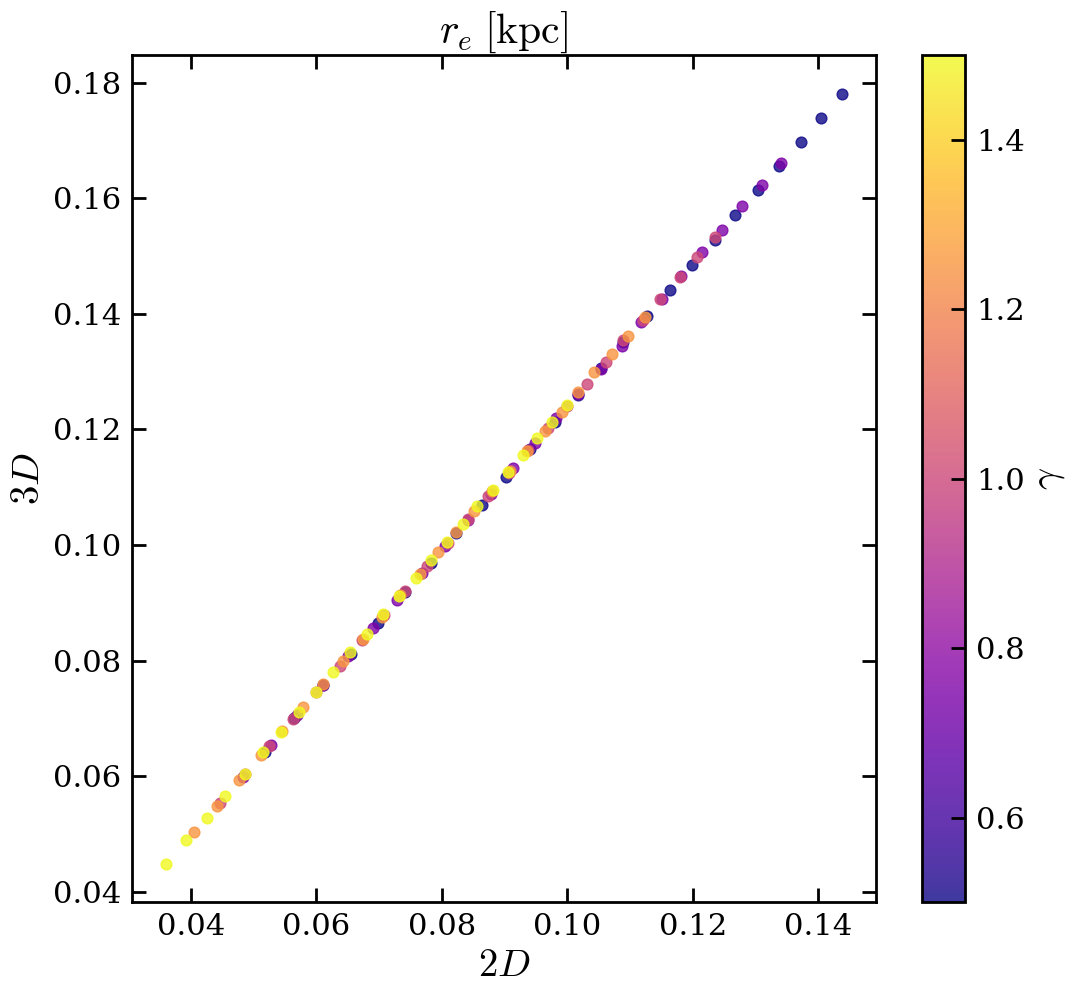

In [16]:
fig, ax = plt.subplots(figsize=(12,11))
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,ci in zip(twoDimEff, threeDimEff, gammas):

    im = ax.scatter(xi,yi, c=ci, s=60, vmin=min(gammas), vmax=max(gammas), cmap = "plasma", alpha = 0.8)
        
    mark += 1
fig.colorbar(im, ax=ax, label = "$\gamma$")

#ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))
plt.xlabel("$2D$")
plt.ylabel("$3D$")
plt.title("$r_{e}\;\mathrm{[kpc]}$")
    
plt.show()

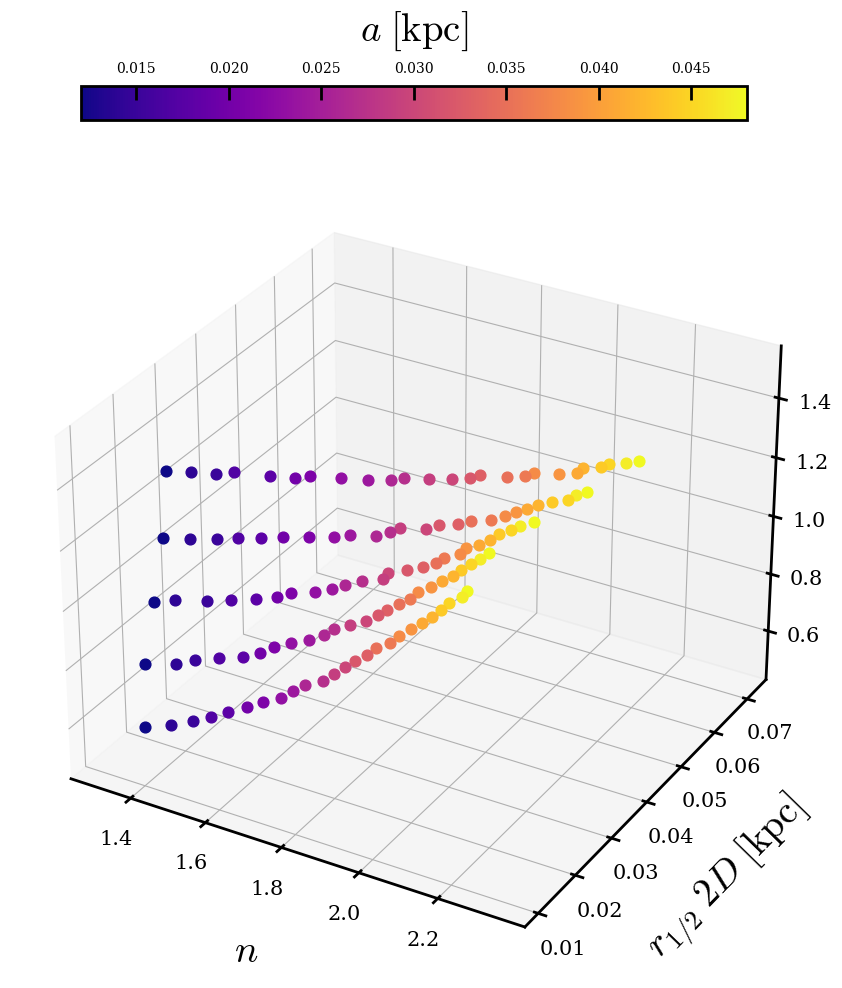

In [17]:
fig = plt.figure(figsize = (12,11))
ax = fig.add_subplot(projection='3d')
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,zi, ci in zip(sersInd ,twoDimHalf, gammas, scales):
    im = ax.scatter(xi,yi,zi, c = ci, s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        
    mark += 1
#fig.colorbar(im, ax=ax, label = "$n$", shrink = 0.5, location = "top")

#ax.legend(handles=legends, fontsize = "24", fancybox=True, shadow=True, loc='lower right', bbox_to_anchor=(1.1, 0.5), bbox_transform = fig.transFigure, edgecolor = "black", framealpha = 1)
fig.tight_layout()
#ax.legend(handles=legends, fontsize = "18")
#plt.xlabel("$r_{1/2}\;\mathrm{[kpc]}$", labelpad = 10)
#plt.ylabel("$a\;\mathrm{[kpc]}$")
ax.set_zlabel('$\gamma$', labelpad = 30)
ax.set_ylabel("$r_{1/2}\;2D\;\mathrm{[kpc]}$", labelpad = 30)
ax.set_xlabel('$n$', labelpad = 30)

#ax.azim = -40
#ax.dist = 10
#ax.elev = 80

#plt.xticks(fontsize=14, rotation=90)
#plt.yticks(fontsize=14, rotation=90)
#plt.zticks(fontsize=14, rotation=90)
cbar = fig.colorbar(im, ax=ax, location = "top", shrink = 0.6)
cbar.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)
cbar.ax.tick_params(labelsize=10) 
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)

plt.show()

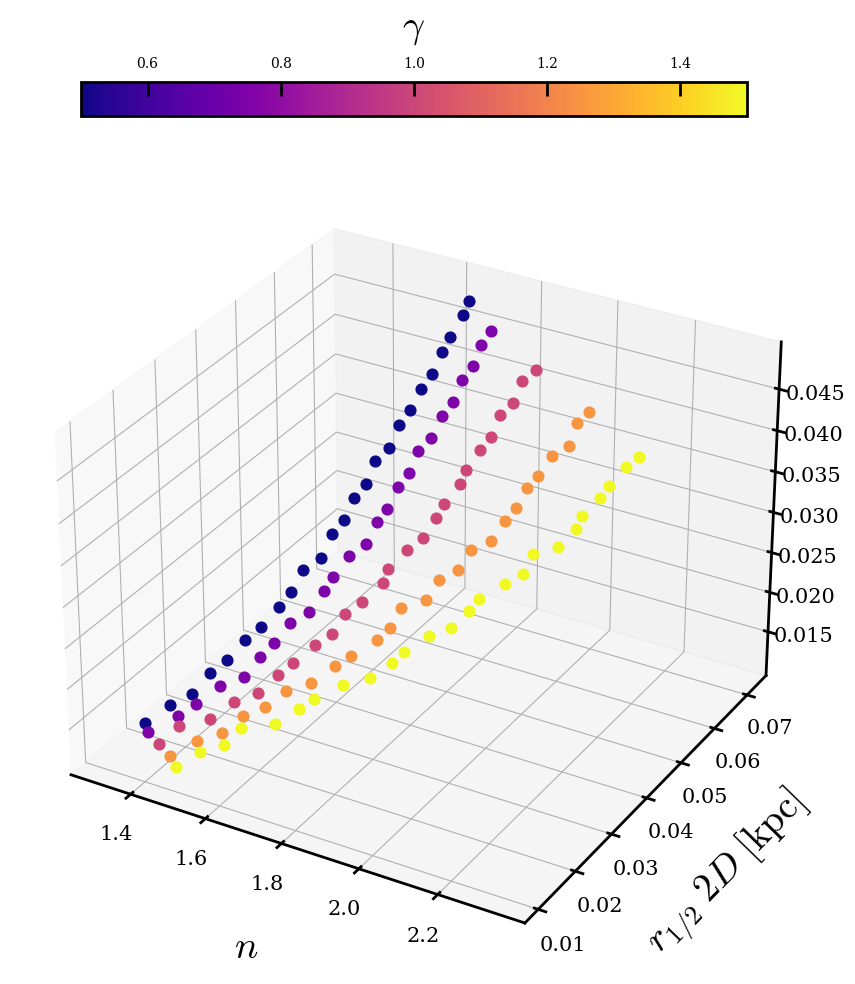

In [18]:
fig = plt.figure(figsize = (12,11))
ax = fig.add_subplot(projection='3d')
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,zi, ci in zip(sersInd ,twoDimHalf, scales, gammas):
    im = ax.scatter(xi,yi,zi, c = ci, s=60, vmin=min(gammas), vmax=max(gammas), cmap = "plasma")
        
    mark += 1
#fig.colorbar(im, ax=ax, label = "$n$", shrink = 0.5, location = "top")

#ax.legend(handles=legends, fontsize = "24", fancybox=True, shadow=True, loc='lower right', bbox_to_anchor=(1.1, 0.5), bbox_transform = fig.transFigure, edgecolor = "black", framealpha = 1)
fig.tight_layout()
#ax.legend(handles=legends, fontsize = "18")
#plt.xlabel("$r_{1/2}\;\mathrm{[kpc]}$", labelpad = 10)
#plt.ylabel("$a\;\mathrm{[kpc]}$")
ax.set_zlabel('$a\;\mathrm{[kpc]}$', labelpad = 30)
ax.set_ylabel("$r_{1/2}\;2D\;\mathrm{[kpc]}$", labelpad = 30)
ax.set_xlabel('$n$', labelpad = 30)

#ax.azim = -40
#ax.dist = 10
#ax.elev = 80

#plt.xticks(fontsize=14, rotation=90)
#plt.yticks(fontsize=14, rotation=90)
#plt.zticks(fontsize=14, rotation=90)
cbar = fig.colorbar(im, ax=ax, location = "top", shrink = 0.6)
cbar.set_label(label = "$\gamma$", labelpad = 15)
cbar.ax.tick_params(labelsize=10) 
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)

plt.show()

In [19]:
'''fig, ax = plt.subplots(figsize=(12,11))
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,ci in zip(twoDimHalf, scales, sersInd):
    if gammas[mark] == 0.5:
        im = ax.scatter(xi,yi, c=ci, marker = "+", s=70, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma")
    if gammas[mark] == 0.75:
        im = ax.scatter(xi,yi, c=ci, marker = "x", s=70, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma")
    if gammas[mark] == 1:
        im = ax.scatter(xi,yi, c=ci, marker = "s", s=70, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma")
    if gammas[mark] == 1.25:
        im = ax.scatter(xi,yi, c=ci, marker = "o", s=70, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma")
    if gammas[mark] == 1.5:
        im = ax.scatter(xi,yi, c=ci, marker = "d", s=70, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma")
        
    mark += 1
fig.colorbar(im, ax=ax, label = "$n$")

ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))
plt.xlabel("$r_{1/2}\;2D\;\mathrm{[kpc]}$")
plt.ylabel("$a\;\mathrm{[kpc]}$")
    
plt.show()''';

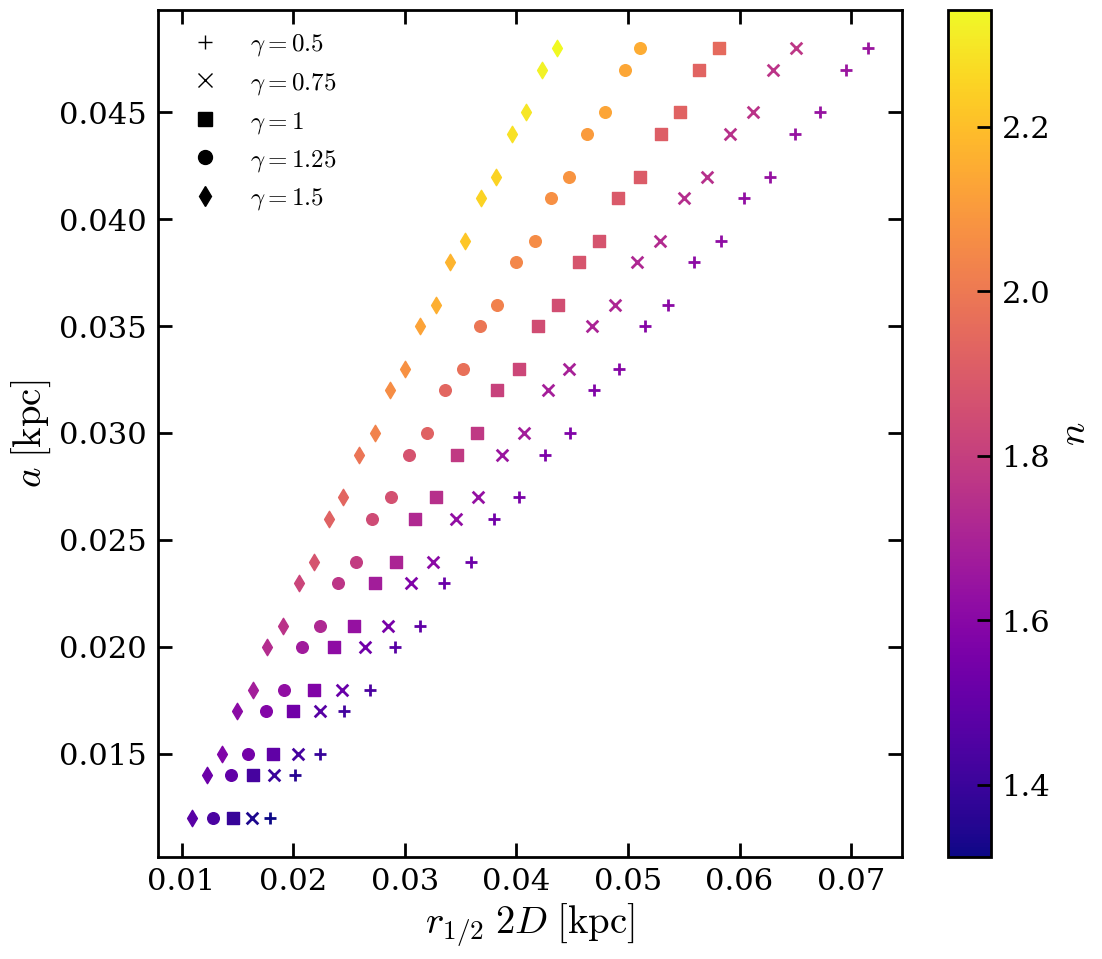

In [20]:
fourParamScatter(twoDimHalf, scales, sersInd, ["$n$", "$r_{1/2}\;2D\;\mathrm{[kpc]}$", "$a\;\mathrm{[kpc]}$"])

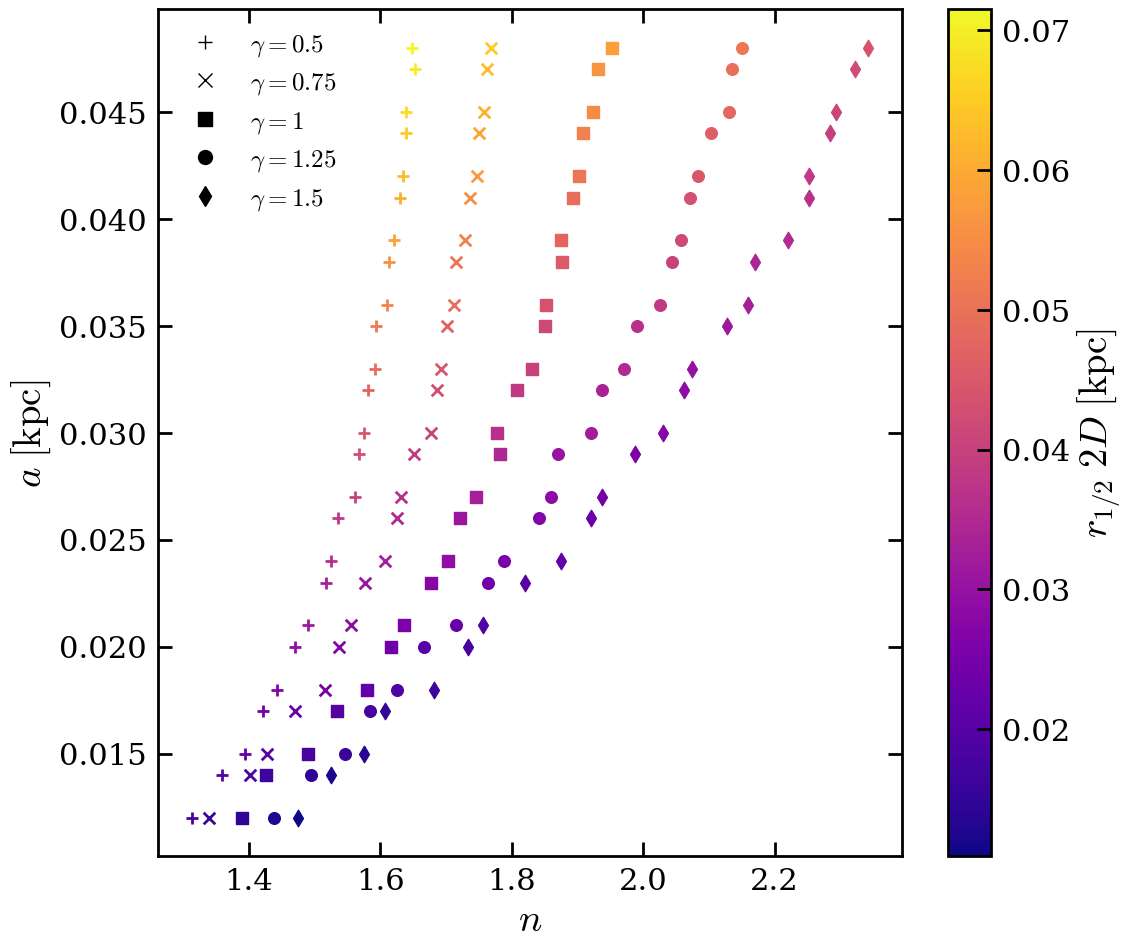

In [21]:
fourParamScatter(sersInd, scales, twoDimHalf, ["$r_{1/2}\;2D\;\mathrm{[kpc]}$", "$n$", "$a\;\mathrm{[kpc]}$"])

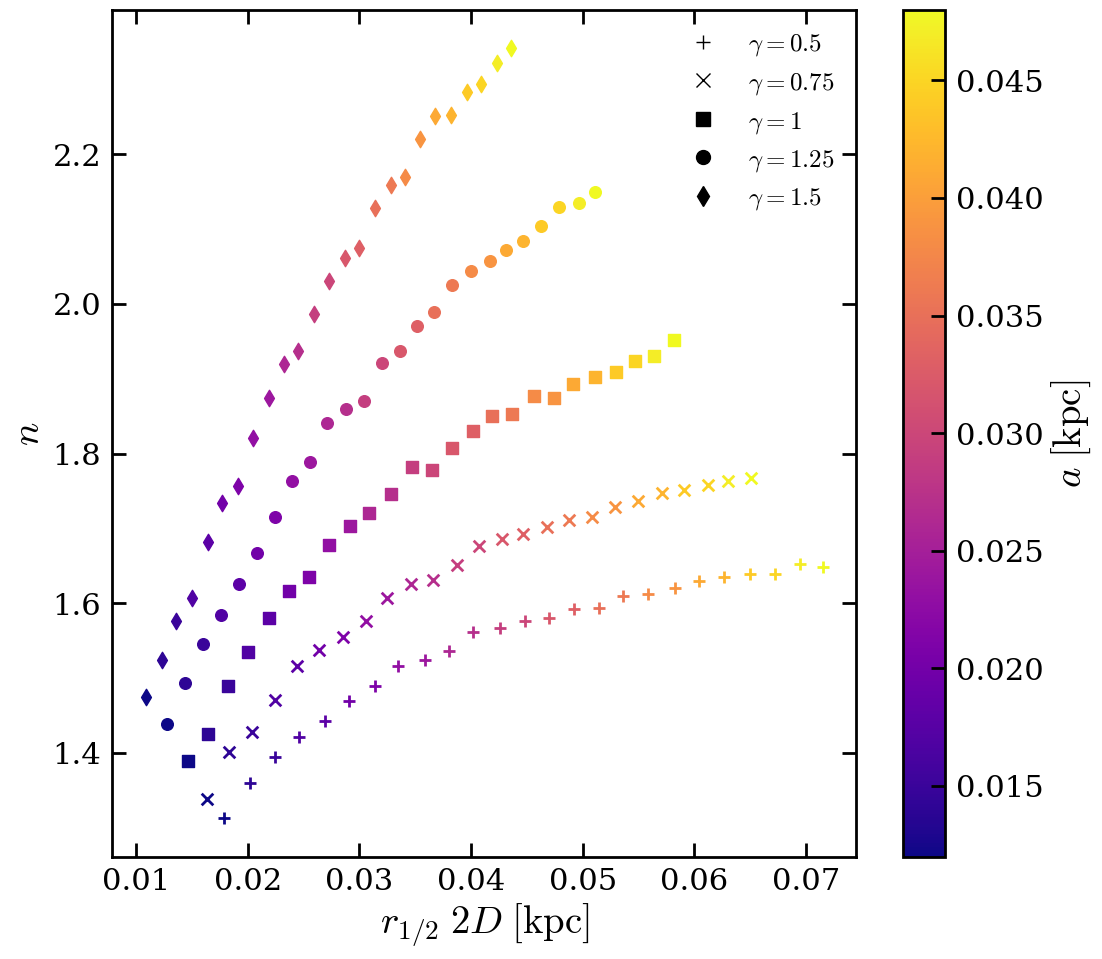

In [22]:
fourParamScatter(twoDimHalf, sersInd, scales, [ "$a\;\mathrm{[kpc]}$", "$r_{1/2}\;2D\;\mathrm{[kpc]}$", "$n$"])

In [25]:
def convPix2Kpc(r):
    rpix = r
    rpix *= 0.05172413793103448 #pix x arc/pix = arc
    rpix *= 15420 * numpy.pi / 648000 #arc x kpc/arc = kpc
    
    return rpix

In [26]:
fitRs = []
for rad in sersRs:
    temp = float(rad)
    fitRs.append(convPix2Kpc(temp))

In [27]:
fitRs_cE = []
for rad in sersRs_cE:
    temp = float(rad)
    fitRs_cE.append(convPix2Kpc(temp))

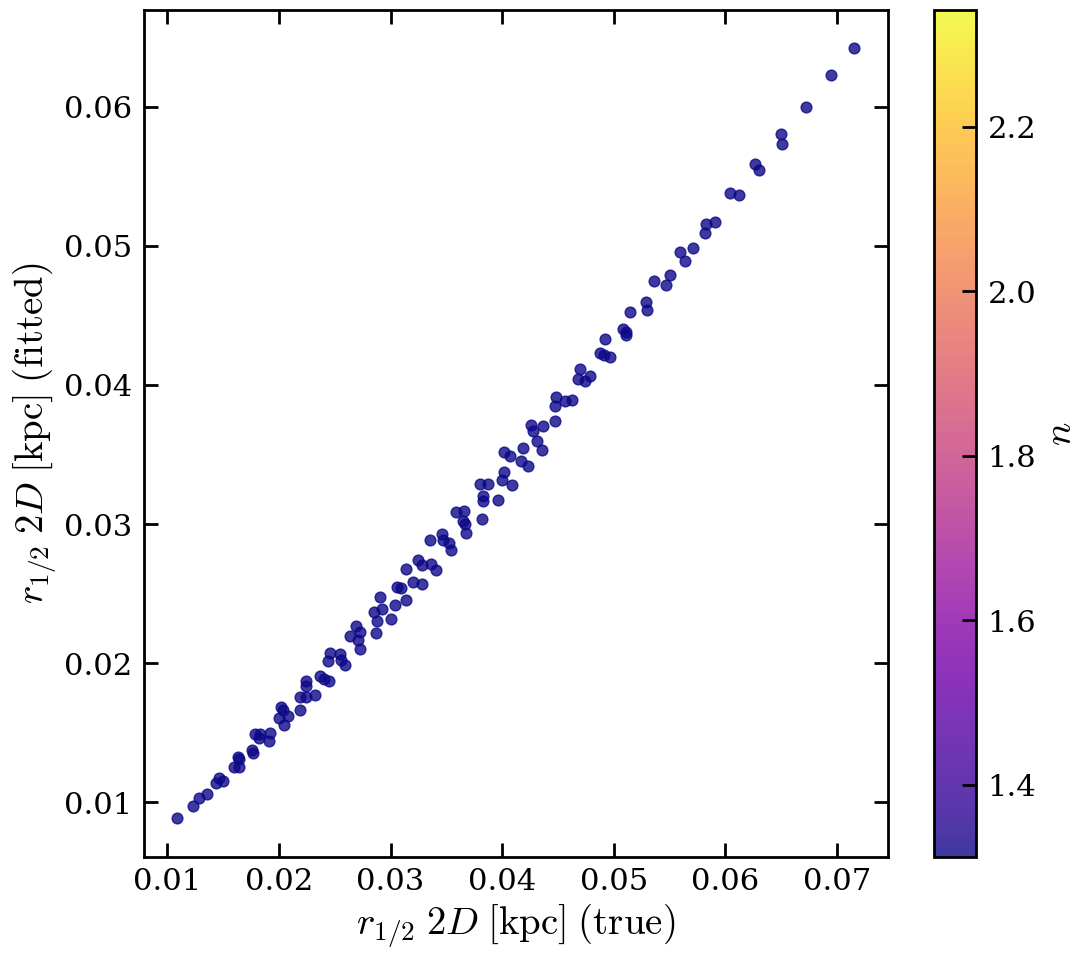

In [28]:
fig, ax = plt.subplots(figsize=(12,11))
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,ci in zip(twoDimHalf, fitRs, scales):

    im = ax.scatter(xi,yi, c=ci, s=60, vmin=min(sersInd), vmax=max(sersInd), cmap = "plasma", alpha = 0.8)
        
    mark += 1
fig.colorbar(im, ax=ax, label = "$n$")

#ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))
plt.xlabel("$r_{1/2}\;2D\;\mathrm{[kpc]}\;\mathrm{(true)}$")
plt.ylabel("$r_{1/2}\;2D\;\mathrm{[kpc]}\;\mathrm{(fitted)}$")
#plt.title("$r_{1/2}\;\mathrm{[kpc]}$")
    
plt.show()

In [29]:
tck = interpolate.bisplrep(sersInd, twoDimHalf, scales)
print(tck)
xNew = numpy.linspace(min(sersInd), max(sersInd), 1000)
yNew = numpy.linspace(min(twoDimHalf), max(twoDimHalf), 1000)
fxy = interpolate.bisplev(xNew, yNew, tck)

[array([1.313, 1.313, 1.313, 1.313, 2.342, 2.342, 2.342, 2.342]), array([0.0109, 0.0109, 0.0109, 0.0109, 0.0715, 0.0715, 0.0715, 0.0715]), array([0.00909396, 0.01801632, 0.02462814, 0.03119619, 0.01580061,
       0.02051636, 0.04184549, 0.0518388 , 0.02109052, 0.02787752,
       0.04099692, 0.06150292, 0.04138514, 0.02635739, 0.06525665,
       0.05660825]), 3, 3]


In [30]:
tck2 = interpolate.bisplrep(sersInd, twoDimHalf, gammas)
print(tck2)
xNew2 = numpy.linspace(min(sersInd), max(sersInd), 1000)
yNew2 = numpy.linspace(min(twoDimHalf), max(twoDimHalf), 1000)
fxy2 = interpolate.bisplev(xNew, yNew, tck2)

[array([1.313, 1.313, 1.313, 1.313, 2.342, 2.342, 2.342, 2.342]), array([0.0109, 0.0109, 0.0109, 0.0109, 0.0715, 0.0715, 0.0715, 0.0715]), array([ 1.20676972, -1.32813321,  1.07909246, -2.25061193,  1.87951263,
        1.51043782, -0.393028  ,  2.88219643,  2.28559173,  0.07667259,
        2.62638027, -0.97401572,  2.68893865,  1.6747438 ,  0.73490111,
        2.34135798]), 3, 3]


In [31]:
#f = interpolate.bisplev(xNew, yNew, tck)

In [32]:
B1, B2 = numpy.meshgrid(xNew, yNew, indexing='xy')

In [33]:
#f = interpolate.bisplev(B1, B2, tck)

In [34]:
spline = interpolate.Rbf(sersInd, twoDimHalf, scales)
Z = spline(B1, B2)
Z2 = spline(xNew, yNew)

In [35]:
print(Z2.shape)

(1000,)


In [36]:
interp = interpolate.NearestNDInterpolator(list(zip(sersInd, twoDimHalf)), scales)

In [37]:
Z3 = interp(B1, B2)

In [38]:
zNew = numpy.linspace(min(scales), max(scales), 1000)

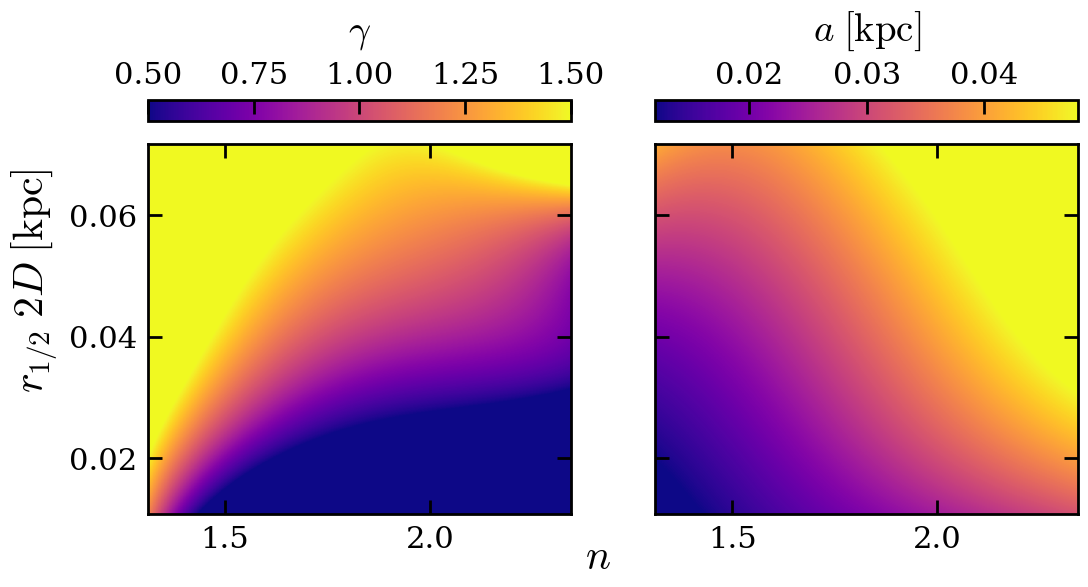

In [41]:
plot2DInter(sersInd, twoDimHalf, scales, gammas)

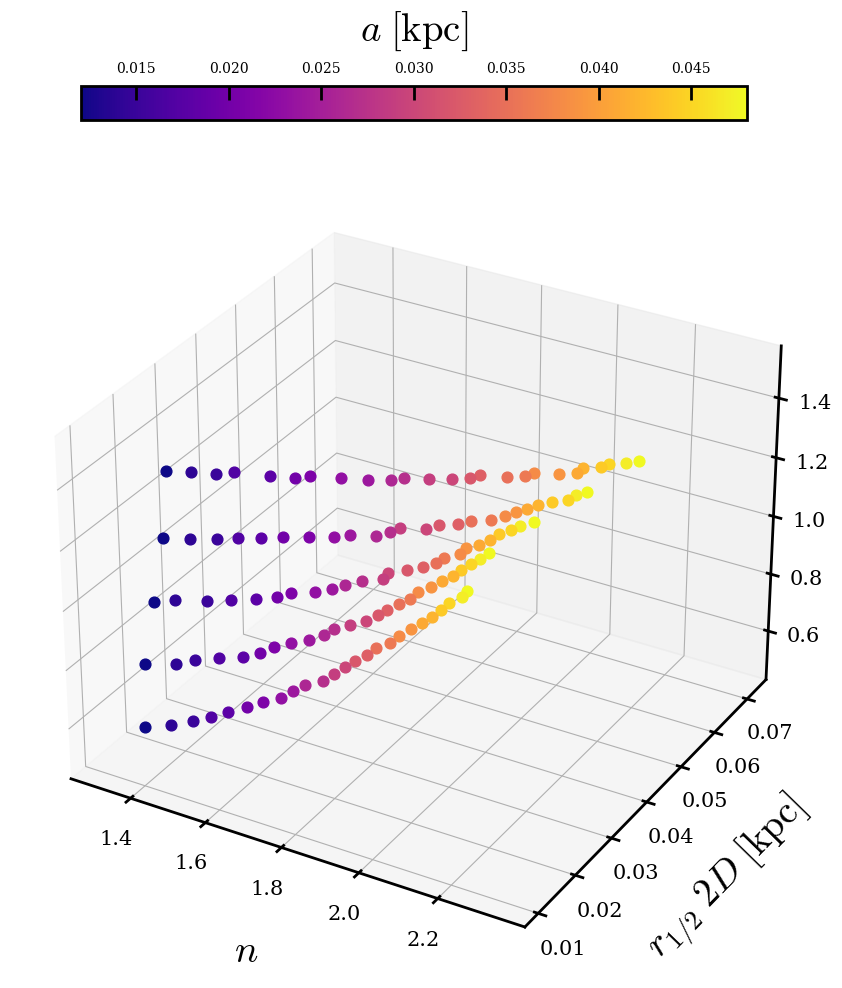

In [44]:
fig = plt.figure(figsize = (12,11))
ax = fig.add_subplot(projection='3d')
markers = numpy.array(["*", "+", "d", "o", "s"])

mark = 0
for xi,yi,zi, ci in zip(sersInd ,twoDimHalf, gammas, scales):
    im = ax.scatter(xi,yi,zi, c = ci, s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        
    mark += 1
#fig.colorbar(im, ax=ax, label = "$n$", shrink = 0.5, location = "top")

#ax.legend(handles=legends, fontsize = "24", fancybox=True, shadow=True, loc='lower right', bbox_to_anchor=(1.1, 0.5), bbox_transform = fig.transFigure, edgecolor = "black", framealpha = 1)
fig.tight_layout()
#ax.legend(handles=legends, fontsize = "18")
#plt.xlabel("$r_{1/2}\;\mathrm{[kpc]}$", labelpad = 10)
#plt.ylabel("$a\;\mathrm{[kpc]}$")
ax.set_zlabel('$\gamma$', labelpad = 30)
ax.set_ylabel("$r_{1/2}\;2D\;\mathrm{[kpc]}$", labelpad = 30)
ax.set_xlabel('$n$', labelpad = 30)

#ax.azim = -40
#ax.dist = 10
#ax.elev = 80

#plt.xticks(fontsize=14, rotation=90)
#plt.yticks(fontsize=14, rotation=90)
#plt.zticks(fontsize=14, rotation=90)
cbar = fig.colorbar(im, ax=ax, location = "top", shrink = 0.6)
cbar.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)
cbar.ax.tick_params(labelsize=10) 
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)

plt.show()

In [48]:
#fig = plt.figure(figsize = (12,11))
#ax = fig.add_subplot()
#im = ax.pcolormesh(Xgrid, Ygrid, Znew)
#cbar = fig.colorbar(im, ax=ax, location = "top", shrink = 0.6)
#im = ax.plot(Znew)
#plt.show()
from matplotlib.gridspec import GridSpec

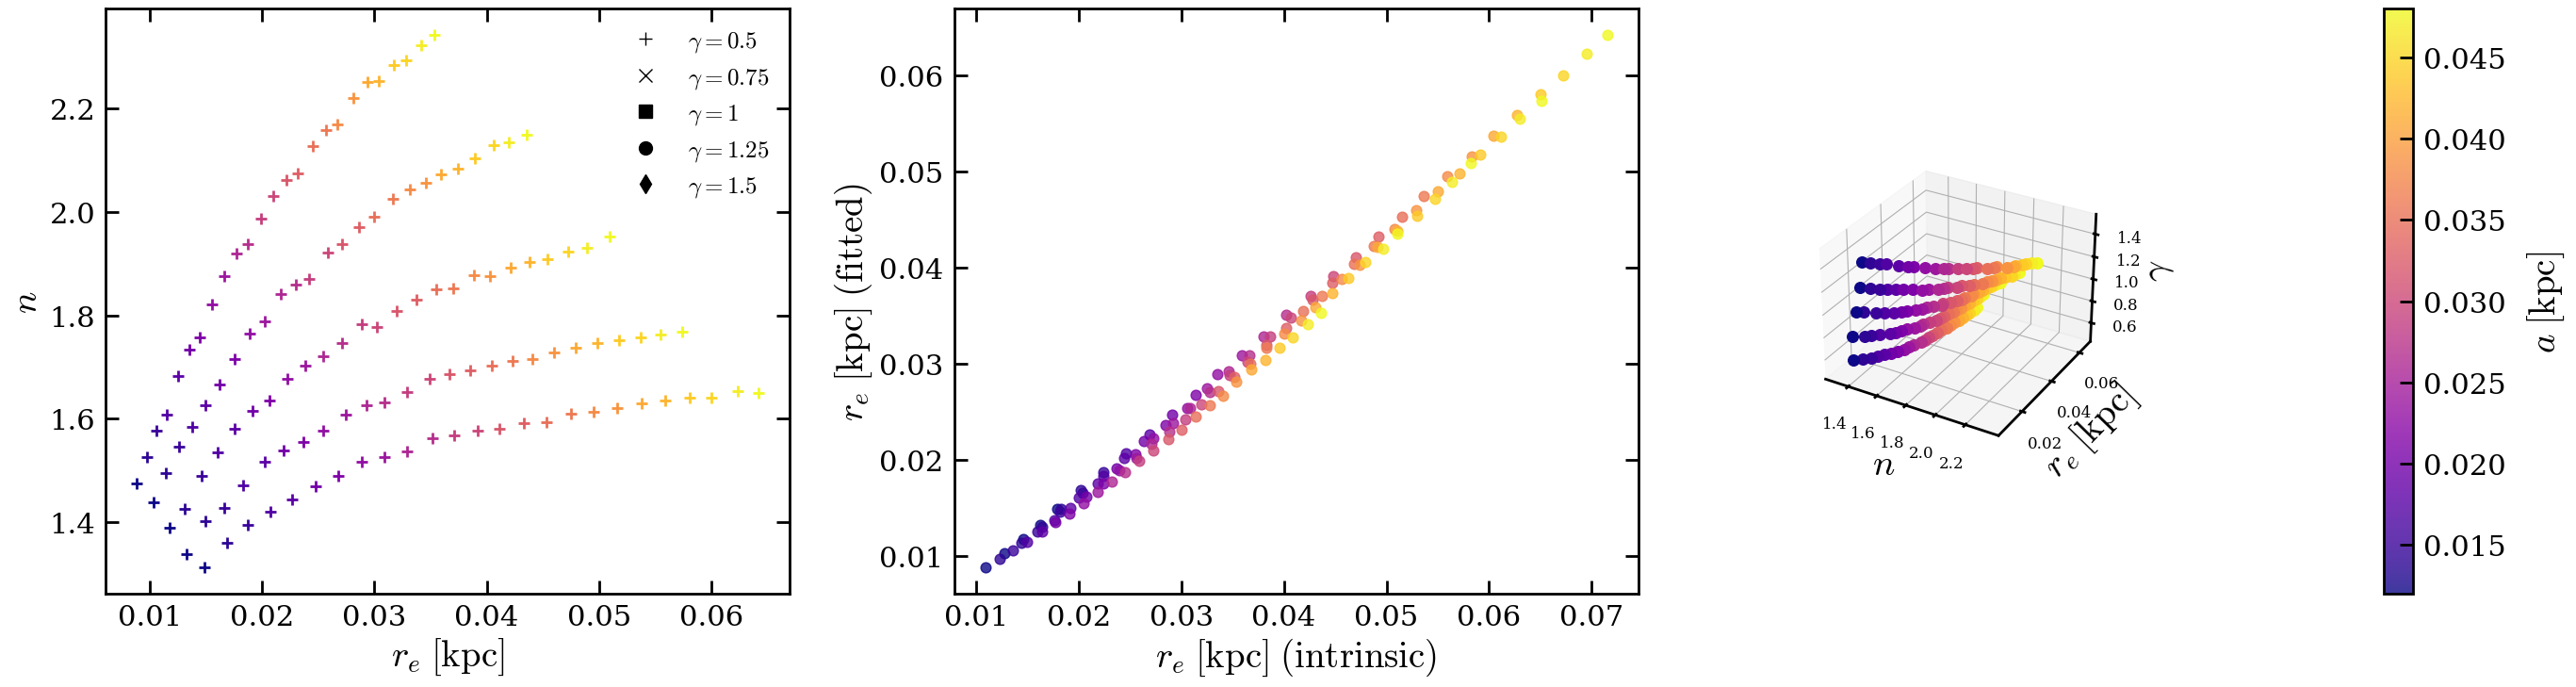

In [49]:
fig = plt.figure(figsize = (28, 8))
gs = GridSpec(1,2,width_ratios = [1, 2])
legends = [Line2D([0], [0], marker='+', label='$\gamma = 0.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='x', label='$\gamma = 0.75$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='s', label='$\gamma = 1$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='o', label='$\gamma = 1.25$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'),
          Line2D([0], [0], marker='d', label='$\gamma = 1.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k')]
    

#1, 3, 1,
ax1 = fig.add_subplot(1,3,1)
mark = 0
for xi,yi,ci in zip(fitRs ,sersInd, scales):
    if gammas[mark] == 0.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "+", s=70, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark] == 0.75:
        im = ax1.scatter(xi,yi, c=ci, marker = "x", s=70, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark] == 1:
        im = ax1.scatter(xi,yi, c=ci, marker = "s", s=70, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark] == 1.25:
        im = ax1.scatter(xi,yi, c=ci, marker = "o", s=70, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark] == 1.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "d", s=70, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        
        mark += 1
    
#fig.colorbar(im, ax=ax1, label = "$a\;\mathrm{[kpc]}$")

ax1.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True)
ax1.set_xlabel("$r_e\;\mathrm{[kpc]}$")
ax1.set_ylabel("$n$")
ax3 = fig.add_subplot(1,3,2)

for xi,yi,ci in zip(twoDimHalf, fitRs, scales):

    im = ax3.scatter(xi,yi, c=ci, s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma", alpha = 0.8)
        
ax3.set_xlabel("$r_{e}\;\mathrm{[kpc]}\;\mathrm{(intrinsic)}$")
ax3.set_ylabel("$r_{e}\;\mathrm{[kpc]}\;\mathrm{(fitted)}$")
#1, 3, 2,
ax2 = fig.add_subplot(1,3,3, projection = "3d")
for xi,yi,zi, ci in zip(sersInd ,fitRs, gammas, scales):
    im2 = ax2.scatter(xi,yi,zi, s = 70, c = ci, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        

fig.tight_layout()
ax2.set_zlabel('$\gamma$', labelpad = 10)
ax2.set_ylabel("$r_e\;\mathrm{[kpc]}$", labelpad = 10)
ax2.set_xlabel('$n$', labelpad = 10)

#cbar = fig.colorbar(im2, ax=ax2, location = "top", shrink = 0.6)
#cbar.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)
#cbar.ax.tick_params(labelsize=10) 
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.zaxis.set_tick_params(labelsize=12)
ax2.dist = 6
'''ax3 = fig.add_subplot(1, 3, 3, projection = "3d")
for xi,yi,zi, ci in zip(sersInd ,fitRs, scales, gammas):
    im3 = ax3.scatter(xi,yi,zi, c = ci, vmin=min(gammas), vmax=max(gammas), cmap = "plasma")


fig.tight_layout()
ax3.set_zlabel('$a\;\mathrm{[kpc]}$', labelpad = 20)
ax3.set_ylabel("$r_e\;\mathrm{[kpc]}$", labelpad = 20)
ax3.set_xlabel('$n$', labelpad = 20)

cbar = fig.colorbar(im3, ax=ax3, location = "top", shrink = 0.6)
cbar.set_label(label = "$\gamma$", labelpad = 15)
cbar.ax.tick_params(labelsize=10) 
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
ax3.zaxis.set_tick_params(labelsize=12)

'''
#fig.colorbar(im, ax=ax3, label = "$a$")

#ax.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.5))

    #ax.legend(handles=legends, fontsize = "18")
#plt.xlabel(labels[1])
#plt.ylabel(labels[2])
cbar = fig.colorbar(im, ax=ax2, location = "right", pad = 0.4)
cbar.set_label(label = "$a\;\mathrm{[kpc]}$",labelpad = 15)
fig.tight_layout()
plt.show()
#plt.show()

In [50]:
def plot2DInter(sers, r, a, gamm, print = False, scatter = False):
    
    tck = interpolate.bisplrep(sers, r, a)
    
    if print:
        print(tck)
        
    #xNew = numpy.linspace(min(sers), max(sers), 1000)
    #yNew = numpy.linspace(min(r), max(r), 1000)
    xNew = numpy.linspace(min(sers), max(sers), 1000)
    yNew = numpy.linspace(min(r), max(r), 1000)
    B1, B2 = numpy.meshgrid(xNew, yNew, indexing='xy')
    fxy = interpolate.bisplev(xNew, yNew, tck)
    #fxy = interpolate.bisplev(B1[:,0], B2[0,:], tck)

    tck2 = interpolate.bisplrep(sers, r, gamm, quiet = 0)
    fxy2 = interpolate.bisplev(xNew, yNew, tck2)
    #fxy2 = interpolate.bisplev(B1[:,0], B2[0,:], tck2)
    if print:
        print(tck2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
    
    
    im = ax1.pcolor(xNew, yNew, fxy2.T, cmap = "plasma", vmin = min(gamm), vmax = max(gamm))
    #im = ax1.pcolor(B1, B2, fxy2, cmap = "plasma")#, vmin = min(gamm), vmax = max(gamm))
    
    if scatter:
        for xi1, yi1, ci1 in zip(sers, r, gamm):
            _ = ax1.scatter(xi1, yi1, c=ci1, vmin = min(gamm), vmax = max(gamm), cmap = "plasma")#, edgecolors = "black")
            
    cbar1 = fig.colorbar(im, ax=ax1, location = "top")
    cbar1.set_label(label = "$\gamma$", labelpad = 15)

    im1 = ax2.pcolor(xNew, yNew, fxy.T, cmap = "plasma", vmin = min(a), vmax = max(a))
    #im1 = ax2.pcolor(B1, B2, fxy, cmap = "plasma", vmin = min(a), vmax = max(a))

    
    if scatter:
        for xi, yi, ci in zip(sers, r, a):
            __ = ax2.scatter(xi, yi, c=ci, vmin = min(a), vmax = max(a), cmap = "plasma")
            
    cbar2 = fig.colorbar(im1, ax=ax2, location = "top")
    cbar2.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)

    fig.text(0.5, 0.02, '$n$', ha='center')
    fig.text(0.01, 0.5, '$r_{1/2}\;2D\;\mathrm{[kpc]}$', va='center', rotation='vertical')

    plt.show()
    return

In [51]:
a = scales 
r = fitRs
sers = sersInd
gamm = gammas
scatter = True
tck = interpolate.bisplrep(sers, r, a)
    

        
    #xNew = numpy.linspace(min(sers), max(sers), 1000)
    #yNew = numpy.linspace(min(r), max(r), 1000)
xNew = numpy.linspace(min(sers), max(sers), 1000)
yNew = numpy.linspace(min(r), max(r), 1000)
B1, B2 = numpy.meshgrid(xNew, yNew, indexing='xy')
fxy = interpolate.bisplev(xNew, yNew, tck)
    #fxy = interpolate.bisplev(B1[:,0], B2[0,:], tck)

tck2 = interpolate.bisplrep(sers, r, gamm, quiet = 0)
fxy2 = interpolate.bisplev(xNew, yNew, tck2)
    #fxy2 = interpolate.bisplev(B1[:,0], B2[0,:], tck2)


/usr/local/anaconda/envs/agama-env/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:588: RuntimeWarning: The spline is weighted least-squares polynomial of degree kx and ky.
fp gives the upper bound fp0 for the smoothing factor s	kx,ky=3,3 nx,ny=8,8 m=125 fp=0.030445 s=109.188612
  warnings.warn(RuntimeWarning(_mess))


In [52]:
a_cE = scales_cE
r_cE = fitRs_cE
sers_cE = sersInd_cE
gamm_cE = gammas_cE
scatter = True
tck_cE = interpolate.bisplrep(sers_cE, r_cE, a_cE)
    

        
    #xNew = numpy.linspace(min(sers), max(sers), 1000)
    #yNew = numpy.linspace(min(r), max(r), 1000)
xNew_cE = numpy.linspace(min(sers_cE), max(sers_cE), 1000)
yNew_cE = numpy.linspace(min(r_cE), max(r_cE), 1000)
B1, B2_cE = numpy.meshgrid(xNew_cE, yNew_cE, indexing='xy')
fxy_cE = interpolate.bisplev(xNew_cE, yNew_cE, tck_cE)
    #fxy = interpolate.bisplev(B1[:,0], B2[0,:], tck)

tck2_cE = interpolate.bisplrep(sers_cE, r_cE, gamm_cE, quiet = 0)
fxy2_cE = interpolate.bisplev(xNew_cE, yNew_cE, tck2_cE)
    #fxy2 = interpolate.bisplev(B1[:,0], B2[0,:], tck2)


/usr/local/anaconda/envs/agama-env/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:588: RuntimeWarning: The spline is weighted least-squares polynomial of degree kx and ky.
fp gives the upper bound fp0 for the smoothing factor s	kx,ky=3,3 nx,ny=8,8 m=125 fp=0.038442 s=109.188612
  warnings.warn(RuntimeWarning(_mess))


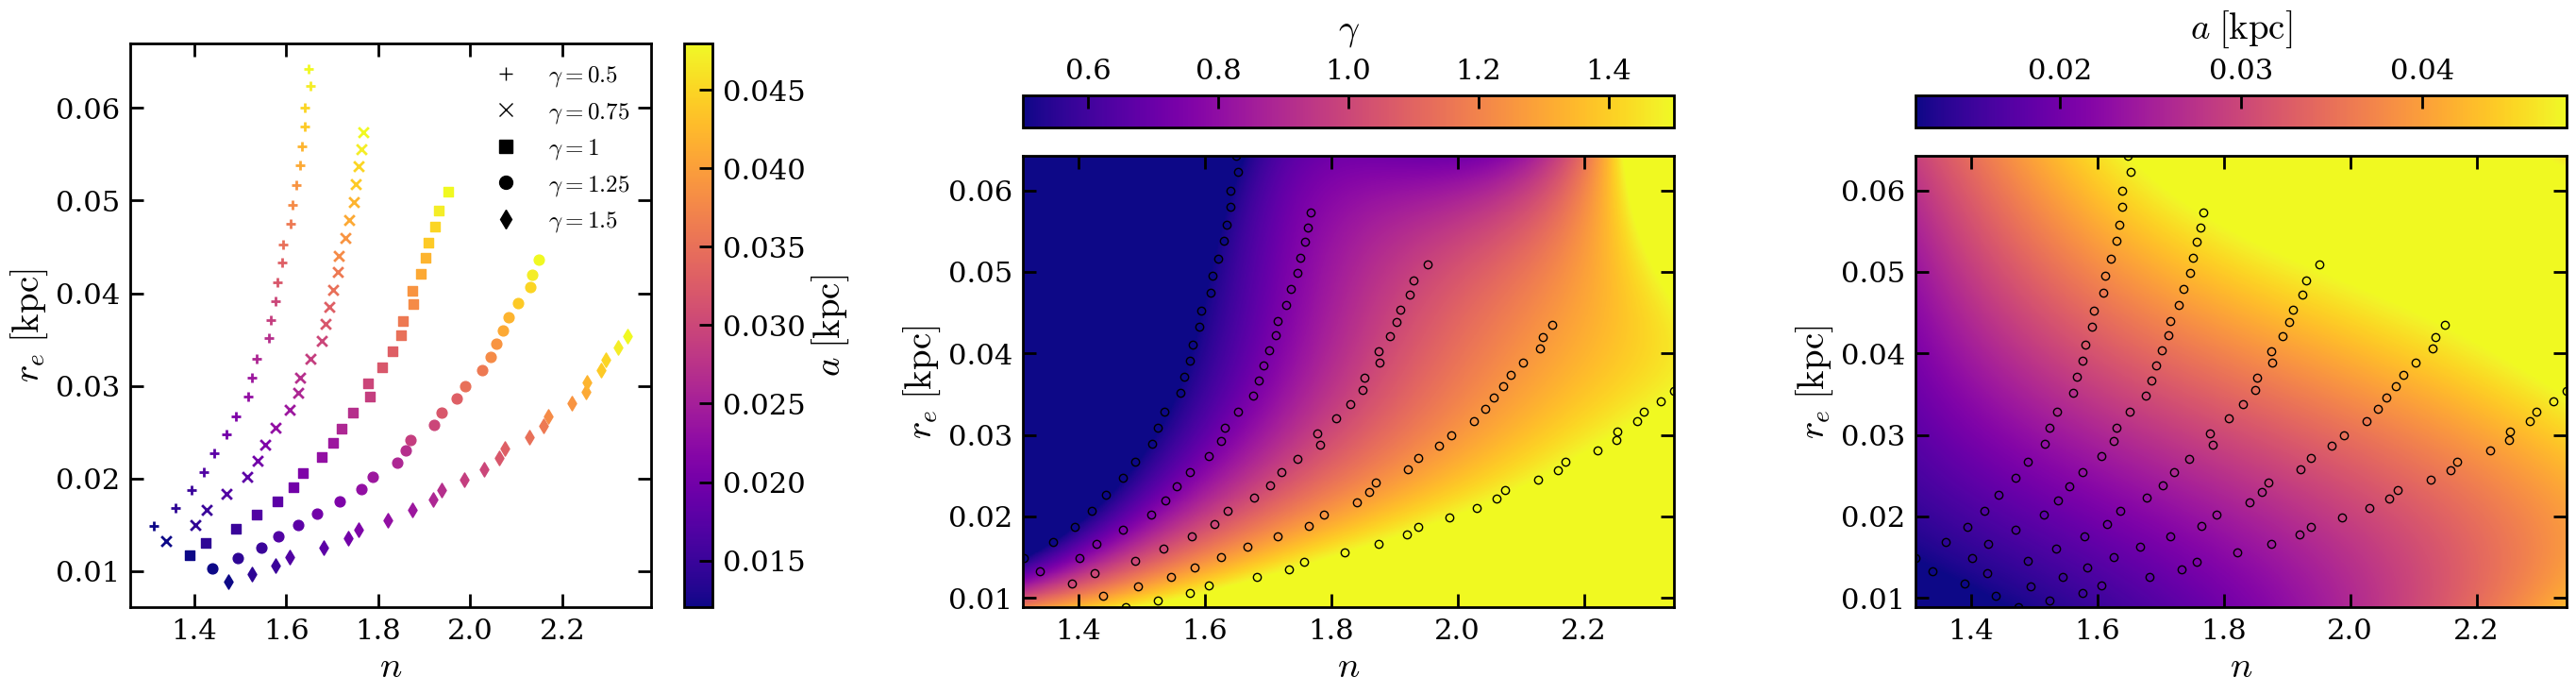

In [53]:
fig = plt.figure(figsize = (28, 8))
#gs = GridSpec(1,2,width_ratios = [1, 2])
legends = [Line2D([0], [0], marker='+', label='$\gamma = 0.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='x', label='$\gamma = 0.75$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='s', label='$\gamma = 1$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='o', label='$\gamma = 1.25$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'),
          Line2D([0], [0], marker='d', label='$\gamma = 1.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k')]
    

#1, 3, 1,
ax1 = fig.add_subplot(1,3,1)
mark1 = 0
for xi,yi,ci in zip(sersInd ,fitRs, scales):
    if gammas[mark1] == 0.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "+", s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 0.75:
        im = ax1.scatter(xi,yi, c=ci, marker = "x", s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1:
        im = ax1.scatter(xi,yi, c=ci, marker = "s", s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1.25:
        im = ax1.scatter(xi,yi, c=ci, marker = "o", s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "d", s=60, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        
    mark1 += 1
    
#fig.colorbar(im, ax=ax1, label = "$a\;\mathrm{[kpc]}$")

ax1.legend(handles=legends, fontsize = "18", fancybox=True, shadow=True)
ax1.set_ylabel("$r_e\;\mathrm{[kpc]}$")
ax1.set_xlabel("$n$")

    
ax2 = fig.add_subplot(1,3,2)
    
    
im1 = ax2.pcolor(xNew, yNew, fxy2.T, cmap = "plasma", vmin = min(gamm), vmax = max(gamm))
    #im = ax1.pcolor(B1, B2, fxy2, cmap = "plasma")#, vmin = min(gamm), vmax = max(gamm))
    
if scatter:
    for xi1, yi1, ci1 in zip(sers, r, gamm):
        _ = ax2.scatter(xi1, yi1, c=ci1, vmin = min(gamm), vmax = max(gamm), cmap = "plasma", edgecolors = "black")#, edgecolors = "black")
            
cbar1 = fig.colorbar(im1, ax=ax2, location = "top")
cbar1.set_label(label = "$\gamma$", labelpad = 15)

ax3=fig.add_subplot(1,3,3)

im3 = ax3.pcolor(xNew, yNew, fxy.T, cmap = "plasma", vmin = min(a), vmax = max(a))
    #im1 = ax2.pcolor(B1, B2, fxy, cmap = "plasma", vmin = min(a), vmax = max(a))

if scatter:
    for xi, yi, ci in zip(sers, r, a):
        __ = ax3.scatter(xi, yi, c=ci, vmin = min(a), vmax = max(a), cmap = "plasma", edgecolors = "black")
            
cbar2 = fig.colorbar(im3, ax=ax3, location = "top")
cbar2.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 15)

cbar = fig.colorbar(im, ax=ax1, label = "$a \; \mathrm{[kpc]}$")
ax2.set_ylabel("$r_e\;\mathrm{[kpc]}$")
ax2.set_xlabel("$n$")
ax3.set_ylabel("$r_e\;\mathrm{[kpc]}$")
ax3.set_xlabel("$n$")
plt.tight_layout()
plt.show()
#ax3.text(0.5, 0.02, '$n$', ha='center')
#fig.text(0.01, 0.5, '$r_{1/2}\;2D\;\mathrm{[kpc]}$', va='center', rotation='vertical')


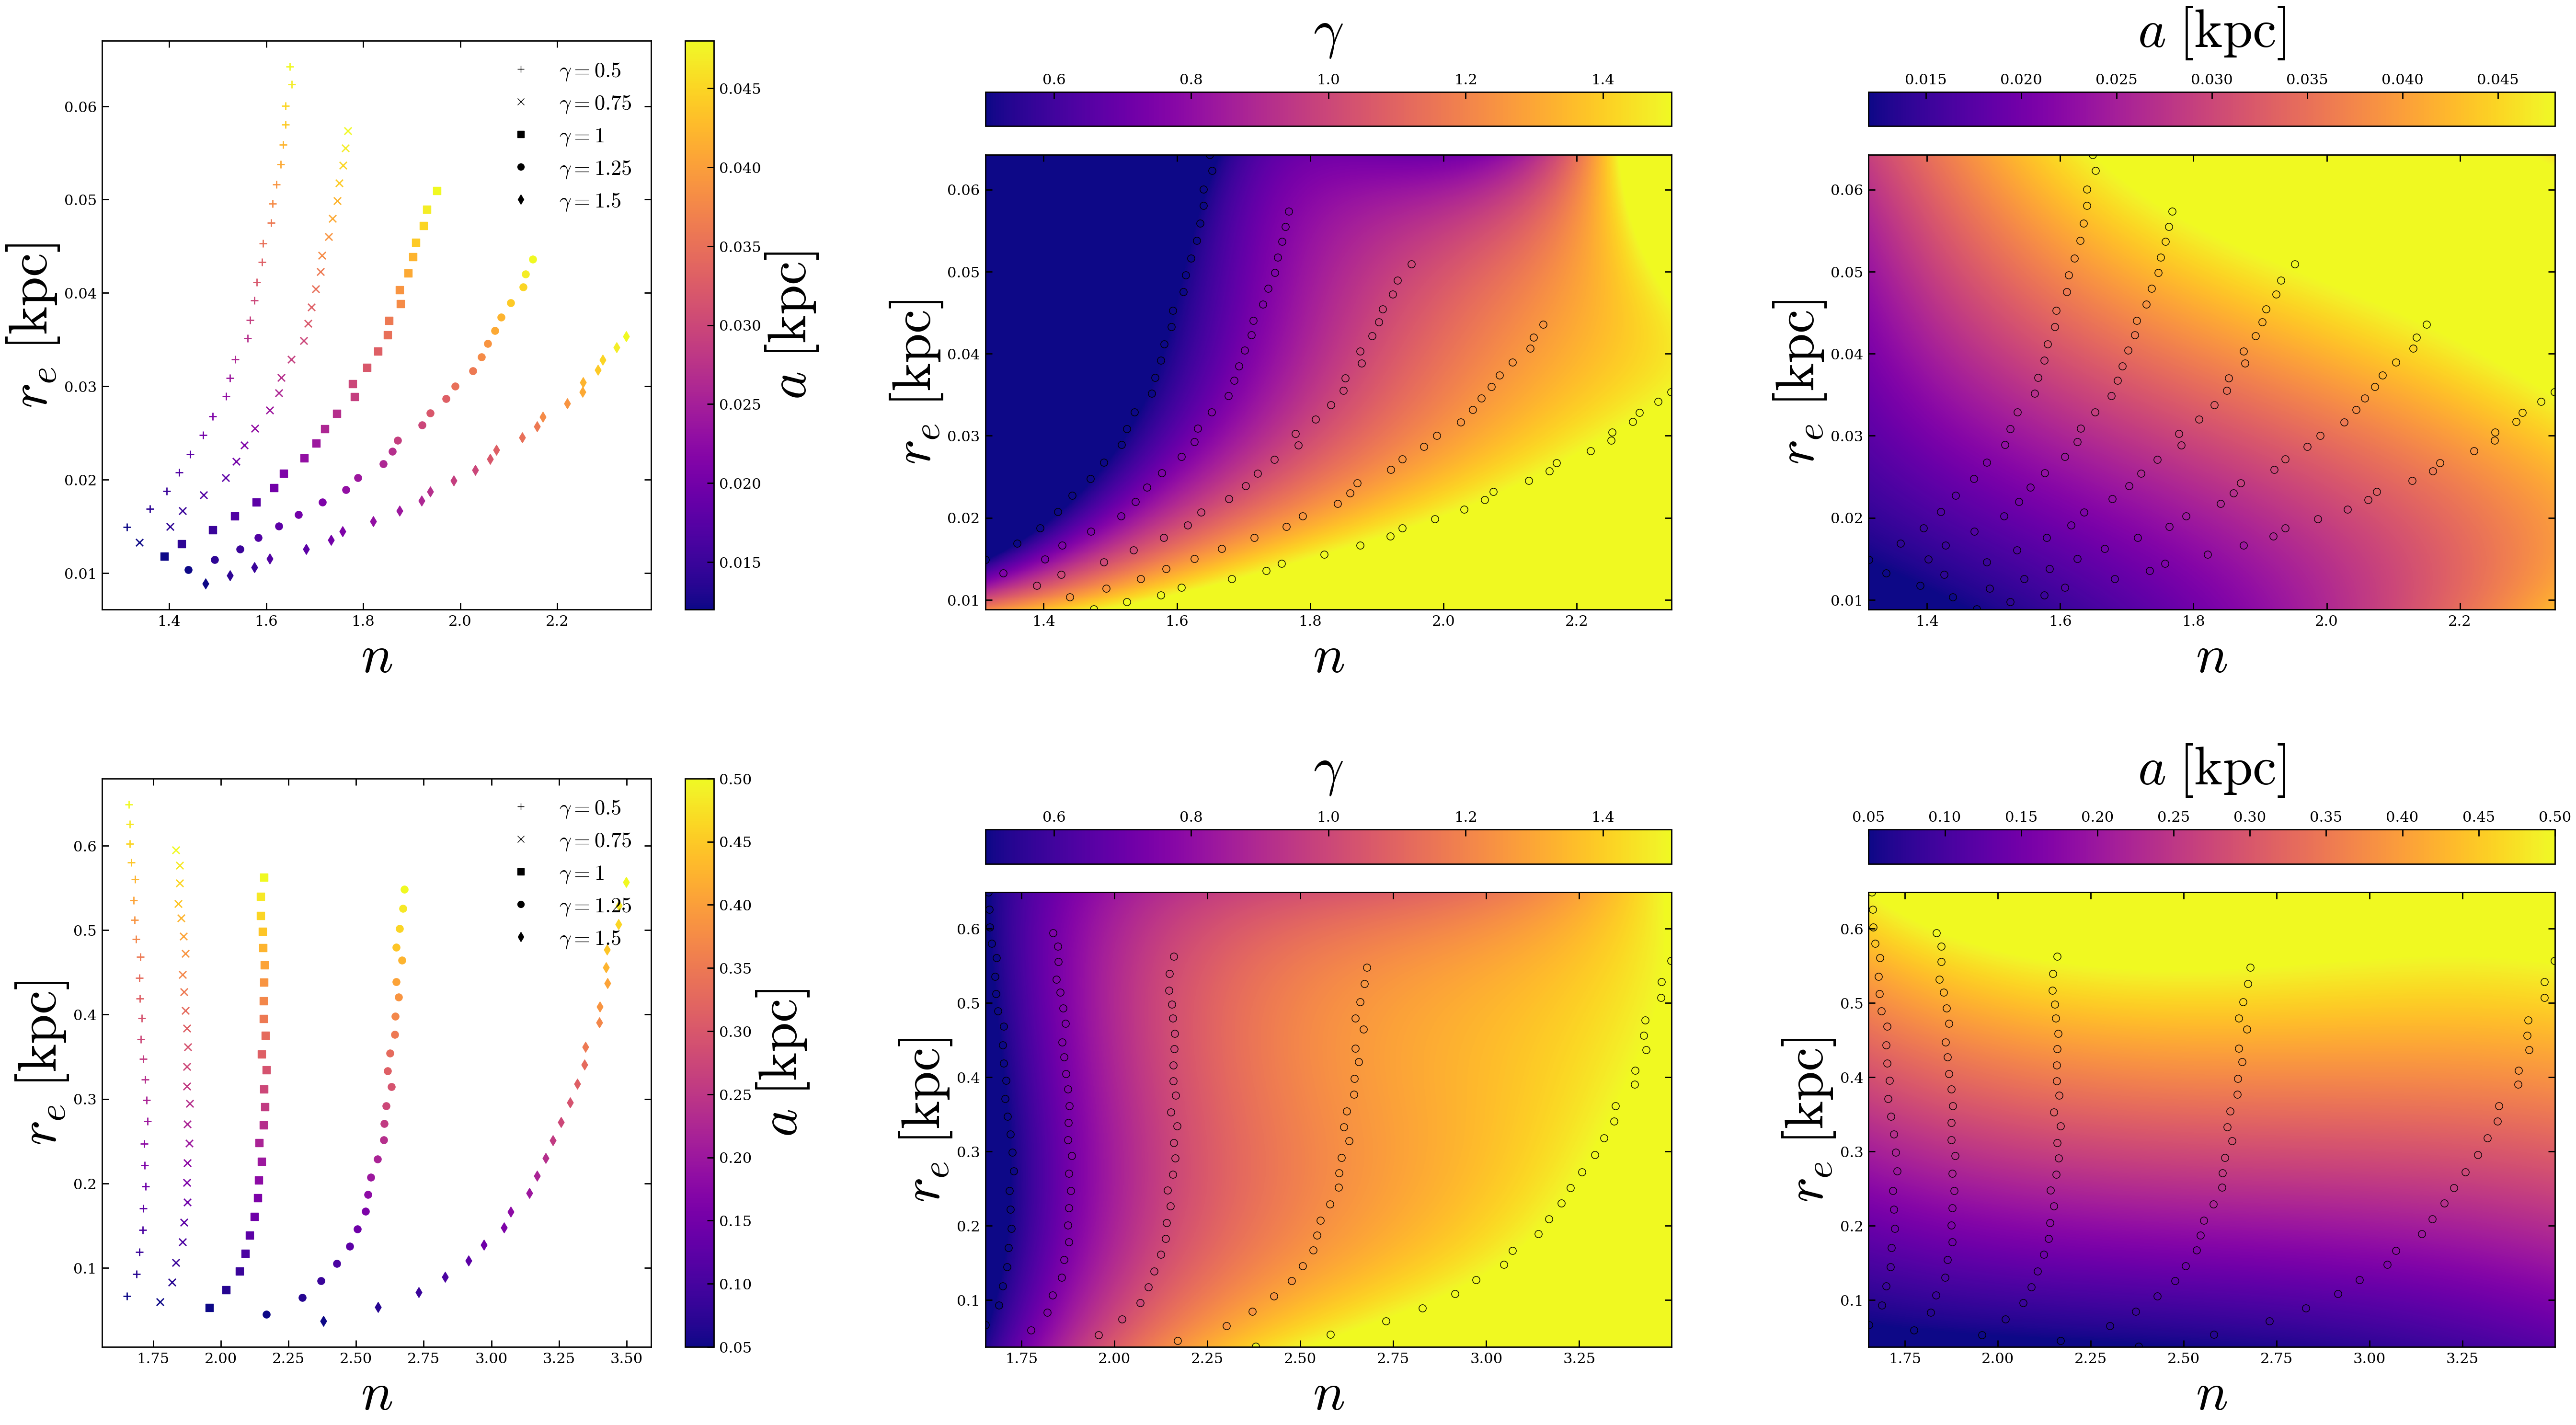

In [65]:
fig = plt.figure(figsize = (56, 32))
#gs = GridSpec(1,2,width_ratios = [1, 2])
legends = [Line2D([0], [0], marker='+', label='$\gamma = 0.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='x', label='$\gamma = 0.75$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='s', label='$\gamma = 1$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'), 
          Line2D([0], [0], marker='o', label='$\gamma = 1.25$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k'),
          Line2D([0], [0], marker='d', label='$\gamma = 1.5$',  markersize=10, linestyle = '', markerfacecolor = 'k', markeredgecolor = 'k')]
    

#1, 3, 1,
#nrows,. ncol, index
ax1 = fig.add_subplot(2,3,1)
mark1 = 0
for xi,yi,ci in zip(sersInd ,fitRs, scales):
    if gammas[mark1] == 0.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "+", s=120, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 0.75:
        im = ax1.scatter(xi,yi, c=ci, marker = "x", s=120, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1:
        im = ax1.scatter(xi,yi, c=ci, marker = "s", s=120, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1.25:
        im = ax1.scatter(xi,yi, c=ci, marker = "o", s=120, vmin=min(scales), vmax=max(scales), cmap = "plasma")
    if gammas[mark1] == 1.5:
        im = ax1.scatter(xi,yi, c=ci, marker = "d", s=120, vmin=min(scales), vmax=max(scales), cmap = "plasma")
        
    mark1 += 1
    
#fig.colorbar(im, ax=ax1, label = "$a\;\mathrm{[kpc]}$")

ax1.legend(handles=legends, fontsize = "32", fancybox=True, shadow=True)
ax1.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax1.set_xlabel("$n$", fontsize = "medium")

    
ax2 = fig.add_subplot(2,3,2)
    
    
im1 = ax2.pcolor(xNew, yNew, fxy2.T, cmap = "plasma", vmin = min(gamm), vmax = max(gamm))
    #im = ax1.pcolor(B1, B2, fxy2, cmap = "plasma")#, vmin = min(gamm), vmax = max(gamm))
    
if scatter:
    for xi1, yi1, ci1 in zip(sers, r, gamm):
        _______ = ax2.scatter(xi1, yi1, c=ci1, vmin = min(gamm), vmax = max(gamm), cmap = "plasma", edgecolors = "black", s = 120)#, edgecolors = "black")
            
cbar1 = fig.colorbar(im1, ax=ax2, location = "top")
cbar1.set_label(label = "$\gamma$", labelpad = 40, fontsize = "medium")

ax3=fig.add_subplot(2,3,3)

im3 = ax3.pcolor(xNew, yNew, fxy.T, cmap = "plasma", vmin = min(a), vmax = max(a))
    #im1 = ax2.pcolor(B1, B2, fxy, cmap = "plasma", vmin = min(a), vmax = max(a))

if scatter:
    for xi, yi, ci in zip(sers, r, a):
        __ = ax3.scatter(xi, yi, c=ci, vmin = min(a), vmax = max(a), cmap = "plasma", edgecolors = "black", s = 120)
            
cbar2 = fig.colorbar(im3, ax=ax3, location = "top")
cbar2.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 40, fontsize = "medium")

ax4 = fig.add_subplot(2,3,4)
mark1 = 0
for xi,yi,ci in zip(sersInd_cE ,fitRs_cE, scales_cE):
    if gammas[mark1] == 0.5:
        im1 = ax4.scatter(xi,yi, c=ci, marker = "+", s=120, vmin=min(scales_cE), vmax=max(scales_cE), cmap = "plasma")
    if gammas[mark1] == 0.75:
        im1 = ax4.scatter(xi,yi, c=ci, marker = "x", s=120, vmin=min(scales_cE), vmax=max(scales_cE), cmap = "plasma")
    if gammas[mark1] == 1:
        im1 = ax4.scatter(xi,yi, c=ci, marker = "s", s=120, vmin=min(scales_cE), vmax=max(scales_cE), cmap = "plasma")
    if gammas[mark1] == 1.25:
        im1 = ax4.scatter(xi,yi, c=ci, marker = "o", s=120, vmin=min(scales_cE), vmax=max(scales_cE), cmap = "plasma")
    if gammas[mark1] == 1.5:
        im1 = ax4.scatter(xi,yi, c=ci, marker = "d", s=120, vmin=min(scales_cE), vmax=max(scales_cE), cmap = "plasma")
        
    mark1 += 1
    
#fig.colorbar(im, ax=ax1, label = "$a\;\mathrm{[kpc]}$")

ax4.legend(handles=legends, fontsize = "32", fancybox=True, shadow=True)
ax4.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax4.set_xlabel("$n$", fontsize = "medium")

    
ax5 = fig.add_subplot(2,3,5)
    
    
im5 = ax5.pcolor(xNew_cE, yNew_cE, fxy2_cE.T, cmap = "plasma", vmin = min(gamm_cE), vmax = max(gamm_cE))
    #im = ax1.pcolor(B1, B2, fxy2, cmap = "plasma")#, vmin = min(gamm), vmax = max(gamm))
    
if scatter:
    for xi1, yi1, ci1 in zip(sers_cE, r_cE, gamm_cE):
        _ = ax5.scatter(xi1, yi1, c=ci1, vmin = min(gamm_cE), vmax = max(gamm_cE), cmap = "plasma", edgecolors = "black", s = 120)#, edgecolors = "black")
            
cbar1 = fig.colorbar(im5, ax=ax5, location = "top")
cbar1.set_label(label = "$\gamma$", labelpad = 40, fontsize = "medium")

ax6=fig.add_subplot(2,3,6)

im6 = ax6.pcolor(xNew_cE, yNew_cE, fxy_cE.T, cmap = "plasma", vmin = min(a_cE), vmax = max(a_cE))
    #im1 = ax2.pcolor(B1, B2, fxy, cmap = "plasma", vmin = min(a), vmax = max(a))

if scatter:
    for xi, yi, ci in zip(sers_cE, r_cE, a_cE):
        ______________ = ax6.scatter(xi, yi, c=ci, vmin = min(a_cE), vmax = max(a_cE), cmap = "plasma", edgecolors = "black", s = 120)
            
cbar2 = fig.colorbar(im6, ax=ax6, location = "top")
cbar2.set_label(label = "$a\;\mathrm{[kpc]}$", labelpad = 40, fontsize = "medium")

cbar_r = fig.colorbar(im, ax=ax1)
cbar_r.set_label(label = "$a \; \mathrm{[kpc]}$", fontsize = "medium")
cbar_k = fig.colorbar(im1, ax=ax4)
cbar_k.set_label(label = "$a \; \mathrm{[kpc]}$" , fontsize = "medium")

ax2.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax2.set_xlabel("$n$", fontsize = "medium")
ax3.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax3.set_xlabel("$n$", fontsize = "medium")
ax5.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax5.set_xlabel("$n$", fontsize = "medium")
ax6.set_ylabel("$r_e\;\mathrm{[kpc]}$", fontsize = "medium")
ax6.set_xlabel("$n$", fontsize = "medium")
matplotlib.rcParams.update({'font.size': 81})
plt.tight_layout()
plt.savefig("RNdraft.png")
plt.show()
#ax3.text(0.5, 0.02, '$n$', ha='center')
#fig.text(0.01, 0.5, '$r_{1/2}\;2D\;\mathrm{[kpc]}$', va='center', rotation='vertical')


In [55]:
print(gammas)

[0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5, 0.5, 0.75, 1.0, 1.25, 1.5]
